# 02450 Project 2


The primary goal of Project 2 is to apply supervised learning techniques (regression and classification) to predict properties or classifications of wood based on the cleaned and scaled dataset from Project 1.

In [821]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
import xlrd
import scipy
from scipy.linalg import svd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

from dtuimldmtools import *
from dtuimldmtools.statistics.statistics import correlated_ttest


### Cleaned and Scaled Data from Project 1

In [822]:
# # Preprocessing of Data

# # Load the data
# data = pd.read_csv('C:/Users/ongji/OneDrive/Documents/DTU/02450 Introduction to Machine Learning and Data Mining/02450-Project-1/usa_wood_data_formatted.csv')


# # Drop columns with significant missing values and irrelevant columns
# removed_columns = ['side_hardness', 'tension_perpendicular_to_grain', 'impact_bending','common_species_name', 'genus', 'species', 'scientific_name']
# data_cleaned = data.drop(columns=removed_columns).dropna()

# # one-hot encoding
# categorical_columns = ['classification', 'moisture_content']
# data_encoded = pd.get_dummies(data_cleaned, columns=categorical_columns)

# # Target attribute
# target_variable = 'specific_gravity'
# X = data_encoded.drop(columns=[target_variable])
# y = data_encoded[target_variable].values

# # Split data into test/train
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# #print(X_train)

# # Identify continuous and categorical features
# continuous_features_train = X_train.iloc[:, :6]  
# continuous_features_test = X_test.iloc[:, :6]  
# categorical_features_train = X_train.iloc[:, 6:]
# categorical_features_test = X_test.iloc[:, 6:]

# # Scale the continuous features
# scaler = StandardScaler()
# continuous_features_train_scaled = scaler.fit_transform(continuous_features_train)
# continuous_features_test_scaled = scaler.transform(continuous_features_test)

# # Combine back scaled continuous features and categorical features
# X_train_scaled = np.concatenate([continuous_features_train_scaled, categorical_features_train.values], axis=1)
# X_test_scaled = np.concatenate([continuous_features_test_scaled, categorical_features_test.values], axis=1)


# attributeNames = list(continuous_features_train.columns) + list(categorical_features_train.columns)
# #print(attributeNames)


# # Scale the target
# target_scaler = StandardScaler()
# y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
# y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))

# X_train_tensor = torch.FloatTensor(X_train_scaled)
# y_train_tensor = torch.FloatTensor(y_train_scaled)
# X_test_tensor = torch.FloatTensor(X_test_scaled)
# y_test_tensor = torch.FloatTensor(y_test_scaled)

# import pandas as pd
# df = pd.DataFrame(X_train_scaled, columns=attributeNames)
# print(df)


In [823]:
# Load the data
data = pd.read_csv('C:/Users/ongji/OneDrive/Documents/DTU/02450 Introduction to Machine Learning and Data Mining/02450-Project-1/usa_wood_data_formatted.csv')

removed_columns = ['side_hardness','tension_perpendicular_to_grain','impact_bending']
data_cleaned = data.drop(columns=removed_columns)
data_cleaned = data_cleaned.dropna()

data_arr = np.array(data_cleaned)  # Attributes are columns
attributeNames = [name for name in data_cleaned.columns]
attributeNames = attributeNames[7:]
attributeNames = np.concatenate((['Wood Type', 'Moisture Content'], attributeNames))
print(attributeNames)

for i in range(data_arr.shape[1]):
    val, count = np.unique(data_arr[:,i], return_counts=True)
    #print(val.shape)        # Print how many unique values of each attribute exist 
                            # Probably dont do one of k coding for first 4 attributes since they have so many unique values

data_adj = data_arr[:,6:]


for i in range(2):
    OoK = np.zeros([data_arr.shape[0], 1])
    val, count = np.unique(data_arr[:,5 - i], return_counts=True)
    
    for j in range(data_arr.shape[0]):
        if data_arr[j,5-i] == val[0]:
            OoK[j, 0] = 1

    data_adj = np.concatenate((OoK, data_adj), 1)


y = data_adj[:,2]
X = np.concatenate((data_adj[:,:2], data_adj[:,3:]), 1)
N, M = X.shape
print(X.shape)

import pandas as pd
df = pd.DataFrame(X, columns=attributeNames)
#print(df)


X = X.astype(np.float32) 
y = y.astype(np.float32)
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

print(X_tensor.shape)
print(y_tensor.shape)

['Wood Type' 'Moisture Content' 'modulus_of_rupture'
 'modulus_of_elasticity' 'work_to_maximum_load'
 'compression_parallel_to_grain' 'compression_perpendicular_to_grain'
 'shear_parallel_to_grain']
(214, 8)
torch.Size([214, 8])
torch.Size([214])


###  Two-Level Cross-Validation Model

K1 = outer loop, 
K2 = inner loop, 
h = no. of hidden neurons

Uses a cross-validation approach to find the best ANN model via finding the best h (number of hidden neurons).


In [824]:
# class ANN(nn.Module):
#     def __init__(self, input_dim, h):
#         super(ANN, self).__init__()
#         self.layer1 = nn.Linear(input_dim, h)
#         self.layer2 = nn.Linear(h,h)
#         self.output_layer = nn.Linear(h, 1)

#     def forward(self, x):
#         x = F.relu(self.layer1(x))
#         x = F.relu(self.layer2(x))
#         x = self.output_layer(x)
#         return x.squeeze()
    
# # Define variables
# K1 = 10
# K2 = 10
    
# def cross_validation(X_tensor, y_tensor, K1=10, K2=10, h_range=20):
    
#     outer_cv = KFold(n_splits=K1, shuffle=True, random_state=42)
#     inner_cv = KFold(n_splits=K2, shuffle=True, random_state=42)

#     ANN_results =[]
#     RLR_results = []
#     Baseline_results = []

#     # Outer Loop
#     for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_tensor)):
#         X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
#         y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]

#         # Standardize
#         scaler_X = StandardScaler()
#         X_train_scaled = scaler_X.fit_transform(X_train)
#         X_test_scaled = scaler_X.transform(X_test)
#         scaler_y = StandardScaler()
#         y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
#         y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

#         X_train_scaled = torch.FloatTensor(X_train_scaled)
#         X_test_scaled = torch.FloatTensor(X_test_scaled)
#         y_train_scaled = torch.FloatTensor(y_train_scaled)
#         y_test_scaled = torch.FloatTensor(y_test_scaled)
        
#         # Baseline
#         y_baseline = torch.mean(y_train_scaled) 
#         baseline_predictions = y_baseline.repeat(y_test.size(0)) 
#         baseline_err = torch.mean((y_test_scaled - baseline_predictions) ** 2).item()  
#         Baseline_results.append((i+1, baseline_err, baseline_predictions.numpy().tolist(), y_test_scaled.tolist())) 

#         # RLR Model
#         opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(np.array(X_train), np.array(y_train), lambdas,K1)
#         lambdaI = opt_lambda * np.eye(X_train_scaled.shape[1])
#         lambdaI[0, 0] = 0  # Do not regularize the bias term
#         w_rlr = np.linalg.solve(X_train_scaled.T @ X_train_scaled + lambdaI, X_train_scaled.T @ y_train_scaled)
#         rlr_predictions = X_test_scaled @ w_rlr
#         rlr_test_err = mean_squared_error(y_test_scaled, rlr_predictions)
#         RLR_results.append((i+1, opt_lambda, rlr_test_err, rlr_predictions.tolist(), y_test_scaled.tolist()))

#         # ANN 
#         best_h = None
#         best_model = None
#         lowest_error = float('inf')        

#         # Inner Loop
#         for h in range(1, h_range + 1): # onyl try up to 20 hidden neurons
#             val_errors = []
#             model = ANN(X_train_scaled.shape[1], h)
#             optimizer = optim.Adam(model.parameters(), lr=0.01)
#             criterion = nn.MSELoss()

#             for train_idx_in, val_idx in inner_cv.split(X_train_scaled):
#                 X_train_inner, X_val = X_train_scaled[train_idx_in], X_train_scaled[val_idx]
#                 y_train_inner, y_val = y_train_scaled[train_idx_in], y_train_scaled[val_idx]

#                 # Training phase
#                 for epoch in range(100):
#                     model.train()
#                     optimizer.zero_grad()
#                     outputs = model(X_train_inner)
#                     loss = criterion(outputs, y_train_inner)
#                     loss.backward()
#                     optimizer.step()
                

#                 # Validation phase
#                 model.eval()
#                 with torch.no_grad():
#                     val_outputs = model(X_val)
#                     #val_outputs = val_outputs.squeeze()
#                     #val_loss = criterion(val_outputs, y_val)
#                     val_error = mean_squared_error(y_val.numpy(), val_outputs.numpy())
#                     val_errors.append(val_error)
                
            
#             # Find best h for this fold
#             avg_val_error = np.mean(val_errors)
#             if avg_val_error < lowest_error: 
#                 lowest_error = avg_val_error
#                 best_h = h
#                 best_model = model
                
                    
#         # Evaluate on test set
#         best_model.eval()
#         with torch.no_grad():
#             test_predictions = best_model(X_test_scaled)
#             ann_test_err = mean_squared_error(y_test_scaled.numpy(), test_predictions.numpy())

#         ANN_results.append((i+1, best_h, ann_test_err, test_predictions.numpy(), y_test_scaled.tolist()))

        
#     return Baseline_results, RLR_results, ANN_results

In [825]:
class ANN(nn.Module):
    def __init__(self, input_dim, h):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(input_dim, h)
        self.layer2 = nn.Linear(h,h)
        self.output_layer = nn.Linear(h, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output_layer(x)
        return x.squeeze()
    

def train_ANN(X_train, y_train, X_test, y_test, h_range, K2):

    inner_cv = KFold(n_splits=K2, shuffle=True, random_state=42)

    best_h = None
    best_model = None
    lowest_error = float('inf') 

    # Inner Loop
    for h in range(1, h_range + 1): # onyl try up to 20 hidden neurons
        val_errors = []
        model = ANN(X_train.shape[1], h)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        criterion = nn.MSELoss()

        for train_idx_in, val_idx in inner_cv.split(X_train):
            X_train_inner, X_val = X_train[train_idx_in], X_train[val_idx]
            y_train_inner, y_val = y_train[train_idx_in], y_train[val_idx]

            # Training phase
            for epoch in range(100):
                model.train()
                optimizer.zero_grad()
                outputs = model(X_train_inner)
                loss = criterion(outputs, y_train_inner)
                loss.backward()
                optimizer.step()
            

            # Validation phase
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                #val_outputs = val_outputs.squeeze()
                #val_loss = criterion(val_outputs, y_val)
                val_error = mean_squared_error(y_val.numpy(), val_outputs.numpy())
                val_errors.append(val_error)
            
        
        # Find best h for this fold
        avg_val_error = np.mean(val_errors)
        if avg_val_error < lowest_error: 
            lowest_error = avg_val_error
            best_h = h
            best_model = model
            
                
    # Evaluate on test set
    best_model.eval()
    with torch.no_grad():
        test_predictions = best_model(X_test)
        ann_test_err = mean_squared_error(y_test.numpy(), test_predictions.numpy())

    return best_h, ann_test_err, test_predictions.numpy()

### Training and Testing Models

In [826]:

# Define variables
K1 = 10
K2 = 10
h_range = 20
    
def cross_validation(X_tensor, y_tensor, K1=10):
    
    outer_cv = KFold(n_splits=K1, shuffle=True, random_state=42)
    #inner_cv = KFold(n_splits=K2, shuffle=True, random_state=42)

    ANN_results =[]
    RLR_results = []
    Baseline_results = []

    # Outer Loop
    for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_tensor)):
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]

        # Standardize
        scaler_X = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        scaler_y = StandardScaler()
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

        X_train_scaled = torch.FloatTensor(X_train_scaled)
        X_test_scaled = torch.FloatTensor(X_test_scaled)
        y_train_scaled = torch.FloatTensor(y_train_scaled)
        y_test_scaled = torch.FloatTensor(y_test_scaled)
        
        # Baseline
        y_baseline = torch.mean(y_train_scaled) 
        baseline_predictions = y_baseline.repeat(y_test.size(0)) 
        baseline_err = torch.mean((y_test_scaled - baseline_predictions) ** 2).item()  
        Baseline_results.append((i+1, baseline_err, baseline_predictions.numpy().tolist(), y_test_scaled.tolist())) 

        # RLR Model
        opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(np.array(X_train), np.array(y_train), lambdas,K1)
        lambdaI = opt_lambda * np.eye(X_train_scaled.shape[1])
        lambdaI[0, 0] = 0  # Do not regularize the bias term
        w_rlr = np.linalg.solve(X_train_scaled.T @ X_train_scaled + lambdaI, X_train_scaled.T @ y_train_scaled)
        rlr_predictions = X_test_scaled @ w_rlr
        rlr_test_err = mean_squared_error(y_test_scaled, rlr_predictions)
        RLR_results.append((i+1, opt_lambda, rlr_test_err, rlr_predictions.tolist(), y_test_scaled.tolist()))

        # ANN 
        best_h, ann_test_error, ann_predictions = train_ANN(X_train_scaled,y_train_scaled,X_test_scaled,y_test_scaled,h_range,K2)
        ANN_results.append((i+1, best_h, ann_test_error, ann_predictions, y_test_scaled.tolist()))

        
    return Baseline_results, RLR_results, ANN_results

In [827]:
Baseline_results, RLR_results, ANN_results = cross_validation(X_tensor, y_tensor)

### Results

In [840]:
# Baseline
print("Baseline: ") 
for result in Baseline_results:
    print(f"Fold {result[0]} | Test MSE: {result[1]:.4f}")


print("\n")

# RLR
print("RLR: ")
for result in RLR_results:
    print(f"Fold {result[0]} | Best lambda: {result[1]} | Test MSE: {result[2]:.4f}")

print("\n")
      
# ANN 
print("ANN: ")
for result in ANN_results:
    print(f"Fold {result[0]} | Best h: {result[1]} | Test MSE: {result[2]:.4f}")


print('\n')

print("Average Test MSE for each model: ")
print(f"Baseline: {np.mean([result[1] for result in Baseline_results])}")
print(f"RLR: {np.mean([result[2] for result in RLR_results])}")
print(f"ANN: {np.mean([result[2] for result in ANN_results])}")

Baseline: 
Fold 1 | Test MSE: 0.8226
Fold 2 | Test MSE: 1.3672
Fold 3 | Test MSE: 0.9326
Fold 4 | Test MSE: 0.5959
Fold 5 | Test MSE: 0.8729
Fold 6 | Test MSE: 0.8137
Fold 7 | Test MSE: 0.8135
Fold 8 | Test MSE: 0.9397
Fold 9 | Test MSE: 1.4439
Fold 10 | Test MSE: 1.6611


RLR: 
Fold 1 | Best lambda: 1.0 | Test MSE: 0.0868
Fold 2 | Best lambda: 1.0 | Test MSE: 0.1763
Fold 3 | Best lambda: 1.0 | Test MSE: 0.1458
Fold 4 | Best lambda: 1.0 | Test MSE: 0.0838
Fold 5 | Best lambda: 1.0 | Test MSE: 0.1020
Fold 6 | Best lambda: 0.1 | Test MSE: 0.0831
Fold 7 | Best lambda: 1.0 | Test MSE: 0.0855
Fold 8 | Best lambda: 1.0 | Test MSE: 0.1115
Fold 9 | Best lambda: 1.0 | Test MSE: 0.1096
Fold 10 | Best lambda: 1.0 | Test MSE: 0.1163


ANN: 
Fold 1 | Best h: 17 | Test MSE: 0.2365
Fold 2 | Best h: 17 | Test MSE: 0.1931
Fold 3 | Best h: 18 | Test MSE: 0.0854
Fold 4 | Best h: 16 | Test MSE: 0.0963
Fold 5 | Best h: 20 | Test MSE: 0.2786
Fold 6 | Best h: 18 | Test MSE: 0.1701
Fold 7 | Best h: 18 | Test 

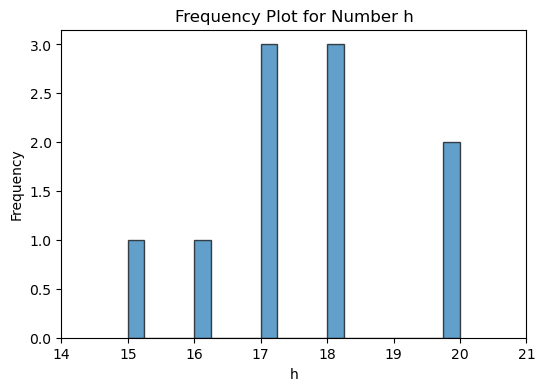

In [835]:
 # Freq plot for h
h_values = [result[1] for result in ANN_results]

plt.figure(figsize=(6,4))
plt.hist(h_values, bins=20, edgecolor='black', alpha=0.7)
plt.xticks(range(int(min(h_values))-1, int(max(h_values))+2, 1))
plt.xlabel('h')
plt.ylabel('Frequency')
plt.title('Frequency Plot for Number h')
plt.show()

Regression Plot to assess how well the model predictions match with the actual data

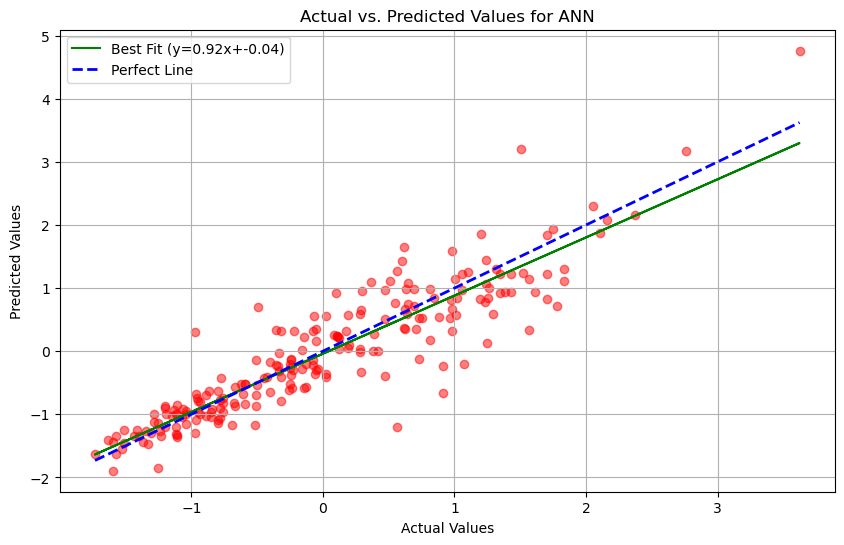

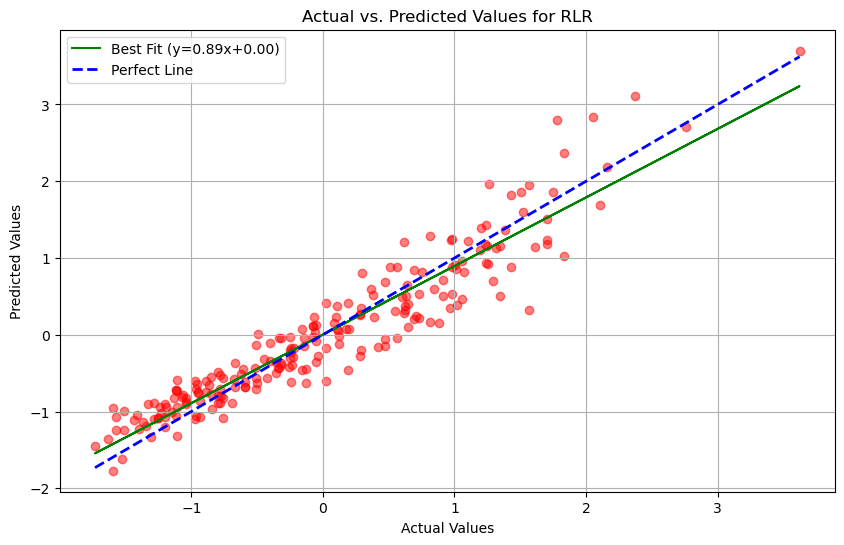

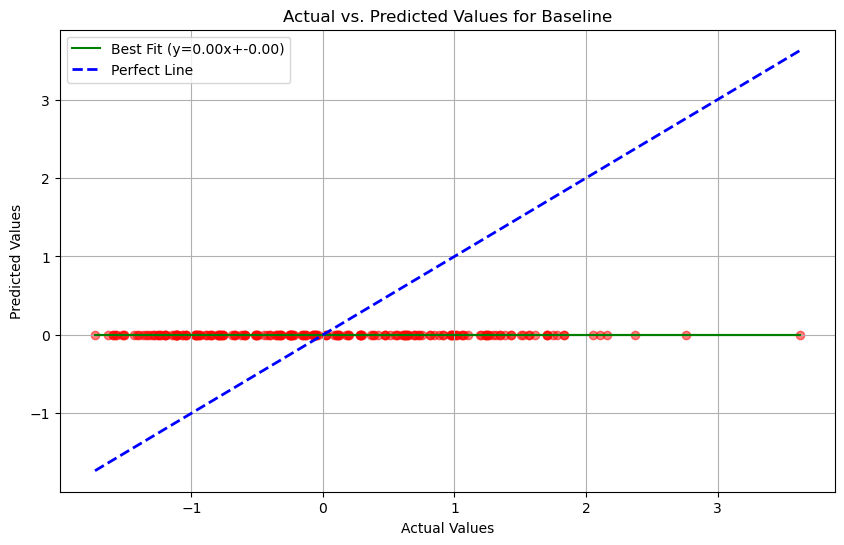

In [836]:
import matplotlib.pyplot as plt

def plot_regression_results_ANN(ANN_results):
    plt.figure(figsize=(10, 6))

    # Aggregate all predictions and actual values
    all_actuals = []
    all_predictions = []
    
    for result in ANN_results:
        fold_number, best_h, test_err, predictions, actuals = result
        all_actuals.extend(actuals)
        all_predictions.extend(predictions)

    # Convert lists to arrays for easier handling
    all_actuals = np.array(all_actuals)
    all_predictions = np.array(all_predictions)

    # Scatter plot
    plt.scatter(all_actuals, all_predictions, alpha=0.5, color='red')
    plt.title('Actual vs. Predicted Values for ANN')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # # Find best fit line (regression line)
    m, b = np.polyfit(all_actuals, all_predictions, 1)
    plt.plot(all_actuals, m*all_actuals + b, color='green', label=f'Best Fit (y={m:.2f}x+{b:.2f})')
  

    # Line of perfect prediction
    plt.plot([all_actuals.min(), all_actuals.max()], [all_actuals.min(), all_actuals.max()], 'blue', lw=2, linestyle='--', label = 'Perfect Line')
    plt.grid(True) 
    plt.legend()
    plt.show() 

def plot_regression_results_RLR(RLR_results):
    plt.figure(figsize=(10, 6))

    # Aggregate all predictions and actual values
    all_actuals = []
    all_predictions = []
    
    for result in RLR_results:
        fold_number, best_lambda, test_err, predictions, actuals = result
        all_actuals.extend(actuals)
        all_predictions.extend(predictions)

    # Convert lists to arrays for easier handling
    all_actuals = np.array(all_actuals)
    all_predictions = np.array(all_predictions)

    # Scatter plot
    plt.scatter(all_actuals, all_predictions, alpha=0.5, color='red')
    plt.title('Actual vs. Predicted Values for RLR')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # # Find best fit line (regression line)
    m, b = np.polyfit(all_actuals, all_predictions, 1)
    plt.plot(all_actuals, m*all_actuals + b, color='green', label=f'Best Fit (y={m:.2f}x+{b:.2f})')
  

    # Line of perfect prediction
    plt.plot([all_actuals.min(), all_actuals.max()], [all_actuals.min(), all_actuals.max()], 'blue', lw=2, linestyle='--', label = 'Perfect Line')
    plt.grid(True) 
    plt.legend()
    plt.show() 

def plot_regression_results_BL(BL_results):
    plt.figure(figsize=(10, 6))

    # Aggregate all predictions and actual values
    all_actuals = []
    all_predictions = []
    
    for result in BL_results:
        fold_number, test, predictions, actuals = result
        all_actuals.extend(actuals)
        all_predictions.extend(predictions)

    # Convert lists to arrays for easier handling
    all_actuals = np.array(all_actuals)
    all_predictions = np.array(all_predictions)

    # Scatter plot
    plt.scatter(all_actuals, all_predictions, alpha=0.5, color='red')
    plt.title('Actual vs. Predicted Values for Baseline')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # # Find best fit line (regression line)
    m, b = np.polyfit(all_actuals, all_predictions, 1)
    plt.plot(all_actuals, m*all_actuals + b, color='green', label=f'Best Fit (y={m:.2f}x+{b:.2f})')
  

    # Line of perfect prediction
    plt.plot([all_actuals.min(), all_actuals.max()], [all_actuals.min(), all_actuals.max()], 'blue', lw=2, linestyle='--', label = 'Perfect Line')
    plt.grid(True) 
    plt.legend()
    plt.show() 

# Call this function with your ANN results
plot_regression_results_ANN(ANN_results)
plot_regression_results_RLR(RLR_results)
plot_regression_results_BL(Baseline_results)

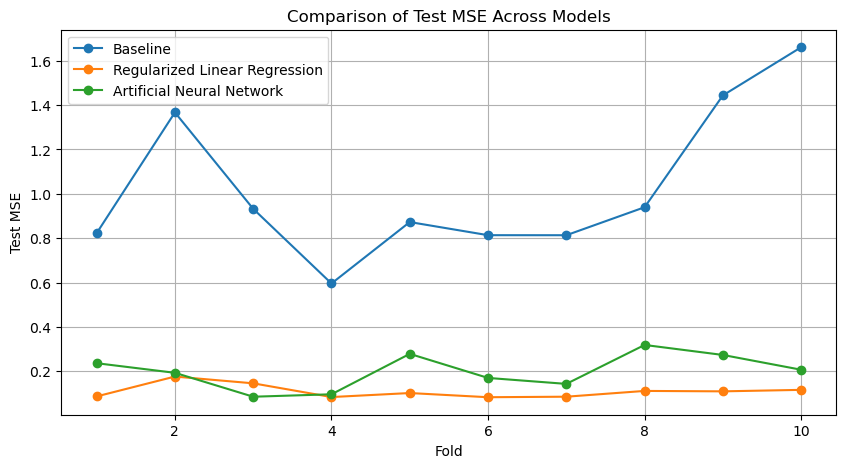

In [ ]:
# Error plot 
folds = np.arange(1, 11)  # 10 folds
baseline_errors = np.array([result[1] for result in Baseline_results])
rlr_errors = np.array([result[2] for result in RLR_results])
ann_errors = np.array([result[2] for result in ANN_results])


plt.figure(figsize=(10, 5))
plt.plot(folds, baseline_errors, marker='o', label='Baseline')
plt.plot(folds, rlr_errors, marker='o', label='Regularized Linear Regression')
plt.plot(folds, ann_errors, marker='o', label='Artificial Neural Network')
plt.xlabel('Fold')
plt.ylabel('Test MSE')
plt.title('Comparison of Test MSE Across Models')
plt.legend()
plt.grid(True)
plt.show()

